In [1]:
!pip install face-detection
!pip install tqdm

Processing c:\users\bharg\appdata\local\pip\cache\wheels\b1\0c\91\4de68877f0c94ff6a4298b19952dabc270f9f63d984a39dd19\face_detection-0.2.1-py3-none-any.whl
Processing c:\users\bharg\appdata\local\pip\cache\wheels\56\b0\fe\4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0\future-0.18.2-py3-none-any.whl
  Using cached dataclasses-0.6-py3-none-any.whl (14 kB)
  Using cached tqdm-4.51.0-py2.py3-none-any.whl (70 kB)


In [2]:
#Source of dataset
#https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset

In [1]:
# Import Required Libraries

import os
import numpy as np
import cv2
import face_detection
from keras.applications import resnet50
from keras.models import Model,load_model
from keras.layers import Dense,Dropout,AveragePooling2D,Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import tqdm
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
# Initialize a Face Detector 
# Confidence Threshold can be Adjusted, Greater values would Detect only Clear Faces

detector = face_detection.build_detector("DSFDDetector", confidence_threshold=.8, nms_iou_threshold=.3)

## TRAINING ##

In [5]:
# Load Pretrained ResNet50 Model (without Last few Layers) 
# Freeze all the Layers previous layers (We dont need to update pretrained model)

base_network  = resnet50.ResNet50(input_shape = (224,224,3),weights='imagenet',include_top=False)
for layer in base_network.layers:
  layer.trainaibale = False

C:\Users\bharg\anaconda3\envs\tf\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [6]:
# Define the Face Mask Classifier Model by adding a few Layers on top of the ResNet50 Pretrained Model

classifier_network = base_network.output
classifier_network = AveragePooling2D(pool_size=(7, 7),name = "Average_Pool_Final")(classifier_network)
classifier_network = Flatten(name = "Flatten_Final")(classifier_network)
classifier_network = Dense(128, activation="relu",name = "Dense_Final")(classifier_network)
classifier_network = Dropout(0.5,name = "Dropout_Final")(classifier_network)
classifier_network = Dense(1, activation="sigmoid", name = "Sigmoid_Classifier" )(classifier_network)

mask_classifier = Model(inputs=base_network.input, outputs=classifier_network)

In [8]:
# Set Path to the Dataset
dataset = "Face Mask Dataset\Train"

In [9]:
# Set the Hyper-Parameters

alpha = 0.00001
n_epochs = 5
mini_batch_size = 32

In [10]:
# Compile the Model

opt = Adam(learning_rate=alpha,decay = alpha/n_epochs)
mask_classifier.compile(optimizer=opt,loss="binary_crossentropy",metrics = ['accuracy'])

In [11]:
# Define a ImageDataGenerator for Real-Time Data Augmentation
# Parameters can be Tuned for controlling the Augmentation

Data_Generator = ImageDataGenerator(rescale=1./255)

In [13]:
# Create a Data_Generator Instance

Train_Data_Generator = Data_Generator.flow_from_directory(dataset,target_size=(224,224),
                                                           class_mode="binary",batch_size=mini_batch_size)

Found 10000 images belonging to 2 classes.


In [14]:
# Train the Model

mask_classifier.fit(x=Train_Data_Generator,
                    steps_per_epoch=(Train_Data_Generator.n//mini_batch_size),
                    epochs=n_epochs)

Epoch 1/5
312/312 [==============================] - 3386s 11s/step - loss: 0.1092 - accuracy: 0.9602
Epoch 2/5
312/312 [==============================] - 3406s 11s/step - loss: 0.0149 - accuracy: 0.9958
Epoch 3/5
312/312 [==============================] - 3422s 11s/step - loss: 0.0083 - accuracy: 0.9976
Epoch 4/5
312/312 [==============================] - 3422s 11s/step - loss: 0.0049 - accuracy: 0.9986
Epoch 5/5
312/312 [==============================] - 3422s 11s/step - loss: 0.0031 - accuracy: 0.9991


In [32]:
# Save the Trained Weights to Disk

#SAVE_PATH = "ResNet50_Classifier.h5"
#mask_classifier.save(SAVE_PATH)
print("Model Saved")

Model Saved


In [3]:
#loaded model from disk if required
mask_classifier=load_model("ResNet50_Classifier.h5")

[[5.744556e-06]]
[[5.1128704e-06]]
[[0.00337792]]
[[0.15765704]]
[[6.6376575e-05]]
[[0.9557533]]
[[0.01282392]]
[[0.9588128]]


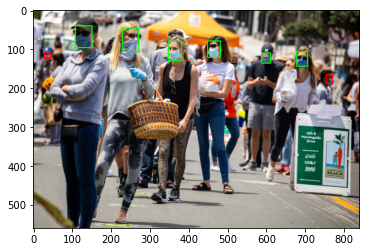

[[0.0010333]]
[[5.298582e-05]]
[[0.97844225]]
[[0.0002326]]
[[0.9275364]]
[[0.9980374]]
[[0.25959966]]
[[0.964571]]
[[0.9171862]]
[[0.9098864]]
[[0.9958852]]


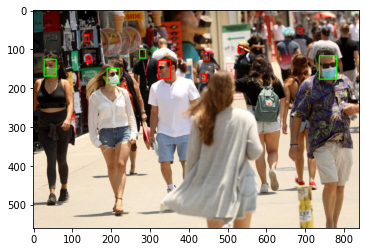

[[0.97583383]]
[[0.99942553]]
[[0.9986268]]
[[0.0072034]]
[[0.00090889]]
[[0.00106788]]
[[0.02186293]]
[[0.958581]]
[[0.87844485]]
[[0.006526]]
[[0.00061629]]
[[0.98996127]]
[[0.9968305]]
[[0.0010696]]
[[0.80766684]]
[[0.727108]]
[[0.9733865]]
[[0.9898218]]


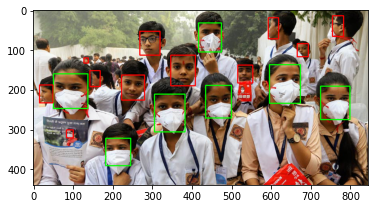

In [4]:
# Test the Model on a Picture

FILE_PATH = ["download (1).jpg","download.jpg","masks-student.jpg"]
for x in FILE_PATH:
    img = cv2.imread(x)
    masked_faces = []
    unmasked_faces = []

    # Detect Faces
    detections = detector.detect(img)

    if detections.shape[0]>0:

      for i in range(detections.shape[0]):

        # Get Co-ordinates
        x1 = int(detections[i][0])
        x2 = int(detections[i][2])
        y1 = int(detections[i][1])
        y2 = int(detections[i][3])

        # Predict Output
        face_arr = cv2.resize(img[y1:y2,x1:x2,::-1], (224, 224), interpolation=cv2.INTER_NEAREST)
        face_arr = np.expand_dims(face_arr, axis=0)
        face_arr = resnet50.preprocess_input(face_arr)
        match = mask_classifier.predict(face_arr)
        print(match)
        if match[0][0]<0.5:
          masked_faces.append([x1,y1,x2,y2])
        else:
          unmasked_faces.append([x1,y1,x2,y2])

    # Put Bounding Box on the Faces (Green:Masked,Red:Not-Masked)
    for f in range(len(masked_faces)):

      a,b,c,d = masked_faces[f]
      cv2.rectangle(img, (a,b), (c,d), (0,255,0), 2)

    for f in range(len(unmasked_faces)):

      a,b,c,d = unmasked_faces[f]
      cv2.rectangle(img, (a,b), (c,d), (0,0,255), 2)

    # Show Results
    plt.imshow(img[:,:,::-1])
    plt.show()